# Naive Bayes learning algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#### Importing the iris dataset

In [2]:
# for implimentation the file has to be uploaded in csv format.
file = 'iris.tmls'
iris = pd.read_csv(file)
#Reading the Iris dataset in TMLS22 format

# remove the second header (r,r,r,r,n)
df = iris.drop(iris.index[0])


#change the last column header name from 'class' to 'target'.
df.rename(columns= lambda x: x.replace('class','target'), inplace=True)
        

    

#### Isolating independent categories

This creates three binary classification scenarios:

* Setosa vs Versicolor

* Versicolor vs Virginica

* Setosa vs Virginica

In [ ]:
#case1: between Iris-setos and Iris-versicolor
df1 = df.iloc[:100, :]
df1 = df1.sample(frac=1)



#case2: between Iris-Versicolor and Iris-virginica
df2= df.iloc[50: 150, :]
df2 = df2.sample(frac=1)



#case3: between Iris-setos and Iris-virginica
df11 = df.iloc[0:50]
df12 = df.iloc[100:]
df3 = pd.concat([df11, df12], axis=0, ignore_index=True)
df3 = df3.sample(frac=1)




## Naive Bayes 
#### Assume that all features are mutually independent

Gaussian Naive Bayes is a simple, efficient, and accurate algorithm and also it assumes that all features are independent, which makes the calculations faster.


- P(y|Xi) = P(X1|y)P(X2|y) ...P(y) / P(Xi)
- P(y|Xi) is the Posterior probability
- P(Xi|y) is the likelihood probability
- P(y) is the prior probability


In [4]:
class NaiveBayes:
   
    def fit(self, X, y):
        number_samples, number_feature = X.shape
        self._target = np.unique(y)
        n_target = len(self._target)
         # init var , mean and prior
        self._mean = np.zeros((n_target, number_feature), dtype= np.float64)
        self._var = np.zeros((n_target, number_feature), dtype= np.float64)
        self._priors = np.zeros(n_target, dtype= np.float64)
        
        for c in self._target:
            X_c = X[np.where(c == y)]
            self._mean[c, :] = X_c.mean(axis=0)
            #print(self._mean[c, :])
            self._var[c, :] = X_c.var(axis=0)
            #print(self._var[c, :])
            self._priors[c] = X_c.shape[0]/ float(number_samples)
            #print(self._priors[c])
        
        
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return y_pred
    
    def predict_proba(self, X):        
        samples = X.shape[0]
        classes = self._priors.shape[0]
        probs = np.zeros((samples, classes))
        for c in range(classes):
            probs[:, c] = self._priors[c] * np.prod(
                np.exp(-(X - self._mean[c, :]) * 2 / (2 * np.sqrt(self._var[c, :]) * 2)) / (np.sqrt(2 * np.pi* self._var[c, :])),
                axis=1)
        prob =np.sum(probs, axis=1, keepdims=True)
            
        probability = probs/ prob 
        return probability
    
    
            
     

#### A function of confusion matrix 

In [5]:
def roc_curve(y_true, y_scores, pos_label=1):
    thresholds = np.sort(np.unique(y_scores))[::-1]
    tpr = []
    fpr = []
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        # Confusion matrix
        # the True Positive Rate and False Positive Rate
        # the True negative Rate and False Negative Rate
        tp = sum((y_true == pos_label) & (y_pred == pos_label))
        fp = sum((y_true != pos_label) & (y_pred == pos_label))
        fn = sum((y_true == pos_label) & (y_pred != pos_label))
        tn = sum((y_true != pos_label) & (y_pred != pos_label))
       
        
        tpr.append((tp) / (tp + fn))
        fpr.append((fp) / (fp + tn))
    return fpr, tpr

def _score(fpr, tpr):
    score = np.trapz(tpr, fpr)
    return score  

### Naive Base Model Crossvalidation

In [6]:
##cross validate the model using 10 folds 

def crossvalidation(X, y ):
    k = 10
    n_samples = len(X)
    fold = n_samples // k
    scores = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 101)
 
    for i in range(k):
        test_start = i * fold
        test_end = (i + 1) * fold
        X_test = X[test_start:test_end]
        y_test = y[test_start:test_end]
        X_train = np.concatenate([X[:test_start], X[test_end:]])
        y_train = np.concatenate([y[:test_start], y[test_end:]])
        
        
        
        nb = NaiveBayes()
        nb.fit(X_train, y_train)
        y_scores = nb.predict_proba(X_test)[:, 1]
        
        #print("y_test", y_test, "y_pred", y_scores)
        fpr, tpr = roc_curve(y_test, y_scores)
        #print("fpr", fpr,"tpr", tpr)
      
        score = _score(fpr, tpr)
        score = np.abs(score)
        scores.append(score)
        
        
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        plt.plot(fpr, tpr, lw=1, alpha=0.3 )
       
       
    std_auc = np.std(scores) 
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,  color='r', alpha=.8 )
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = _score(mean_fpr, mean_tpr)
    #print(mean_auc)
    #print(std_auc)
    plt.plot(mean_fpr , mean_tpr , color='b' , label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Naive Bayes 10-fold Crossvalidation ROC')
    plt.legend(loc="lower right")
    plt.show()

        
        
        

#### *Case 1*: classification of Iris-setos and Iris-versicolor dataset

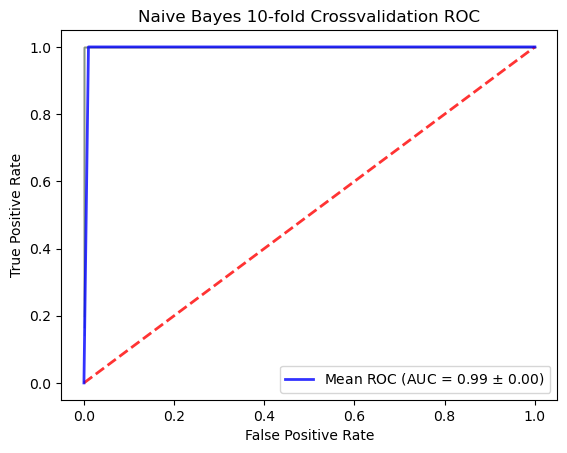

In [7]:
X1 = np.asarray(df1.drop('target', axis=1))
X1 = X1.astype(dtype=np.float64)

y1 = df1['target']

# Getting the unique values of the object

unique_values = np.unique(y1)

# Replacing the values with numerical values

for i, value in enumerate(unique_values):
    y1 = np.where(y1 == value, i, y1)
y1 = np.asarray(y1)
y1 = y1.astype(object)





crossvalidation(X1, y1)






#### *Case 2*: classification of Iris-versicolor and Iris-virginica

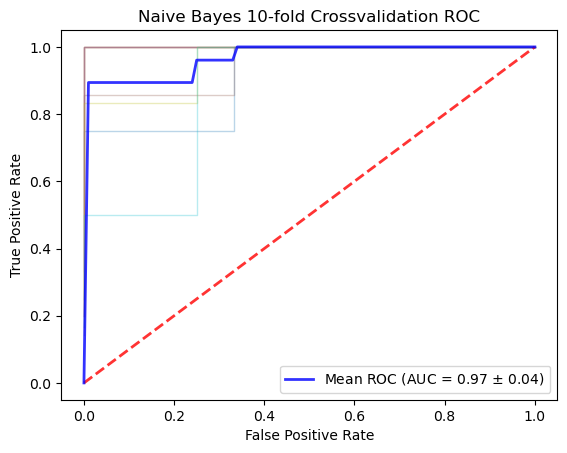

In [8]:

X2 = np.asarray(df2.drop('target', axis=1))
X2 = X2.astype(dtype=np.float64)

y2 = df2['target']
# Getting the unique values of the object
unique_values = np.unique(y2)
# Replacing the values with numerical values
for i, value in enumerate(unique_values):
    y2 = np.where(y2 == value, i, y2)
y2 = np.asarray(y2)
y2 = y2.astype(object)



 
crossvalidation(X2, y2)




#### *Case 3*: classification of Iris-setos and Iris-virginica

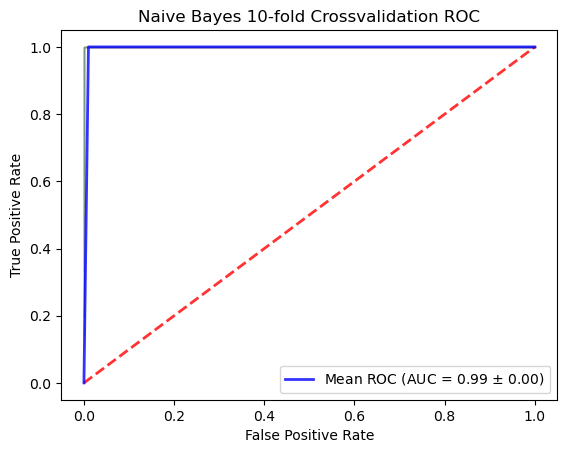

In [9]:
X3 = np.asarray(df3.drop('target', axis=1))
X3 = X3.astype(dtype=np.float64)

y3 = df3['target']
# Getting the unique values of the object
unique_values = np.unique(y3)
# Replacing the values with numerical values
for i, value in enumerate(unique_values):
    y3 = np.where(y3 == value, i, y3)
y3 = np.asarray(y3)

y3 = y3.astype(object)





crossvalidation(X3, y3)



#### Freeze Requirement file

In [3]:
!pip freeze requirement.txt

absl-py==2.0.0
appnope @ file:///home/conda/feedstock_root/build_artifacts/appnope_1649077682618/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1698341106958/work
astunparse==1.6.3
cachetools==5.3.2
certifi==2023.11.17
charset-normalizer==3.3.2
comm @ file:///home/conda/feedstock_root/build_artifacts/comm_1691044910542/work
contourpy==1.2.0
cycler==0.12.1
debugpy @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_30hp2nowkm/croot/debugpy_1690905056188/work
decorator @ file:///home/conda/feedstock_root/build_artifacts/decorator_1641555617451/work
eclipse-sumo==1.17.0
exceptiongroup @ file:///home/conda/feedstock_root/build_artifacts/exceptiongroup_1700579780973/work
executing @ file:///home/conda/feedstock_root/build_artifacts/executing_1698579936712/work
flatbuffers==23.5.26
fonttools==4.46.0
gast==0.4.0
google-auth==2.25.2
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
grpcio==1.60.0
h5py==3.10.0
idna==3.6
importlib-metadata @ file:///